# About

This document describes XES generation method.

In [2]:
%load_ext autoreload
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

In [3]:
%autoreload
from maxes.xes_loader2 import XesLoader
# from maxes.xes_file import XesFile
# from maxes.analyze_xes import AnalyzeXes
# import maxes.analyze_sequence
# import maxes.serialization.serialize
# import maxes.graphs
import maxes.notebooks.utils
import maxes.utils

In [ ]:
maxes.notebooks.utils.init_notebook() # RUN ONLY ONCE

Let's first examine an XES file

XES (Extensible Event Stream) is a file that contains traces (event sequences) of some process.

In [5]:
file_path = maxes.notebooks.utils.get_data_path("other/simple.xes")
log = XesLoader().load(file_path)
log.df

,case:concept:name,concept:name,lifecycle:transition,time:timestamp,call centre,org:resource,location,duration,outcome,case:description
0,1,incoming claim,complete,1970-01-01 00:00:00+00:00,Brisbane,customer,NaN,NaN,NaN,Simulated process instance
1,1,B check if sufficient information is available,start,1970-01-01 00:00:00+00:00,NaN,Call Centre Agent Brisbane,Brisbane,NaN,NaN,Simulated process instance
2,1,B check if sufficient information is available,complete,1970-01-01 00:00:41+00:00,NaN,Call Centre Agent Brisbane,Brisbane,NaN,NaN,Simulated process instance
3,1,B register claim,start,1970-01-01 00:00:41+00:00,NaN,Call Centre Agent Brisbane,NaN,NaN,NaN,Simulated process instance
4,1,B register claim,complete,1970-01-01 00:12:59+00:00,NaN,Call Centre Agent Brisbane,NaN,NaN,NaN,Simulated process instance
...,...,...,...,...,...,...,...,...,...,...
4,3512,S register claim,complete,1970-01-01 02:39:31+00:00,NaN,Call Centre Agent Sydney,NaN,NaN,NaN,Simulated process instance
5,3512,determine likelihood of claim,start,1970-01-01 06:56:04+00:00,NaN,Claims handler,NaN,NaN,NaN,Simulated process instance
6,3512,determine likelihood of claim,complete,1970-01-01 06:56:35+00:00,NaN,Claims handler,NaN,NaN,NaN,Simulated process instance
7,3512,end,start,1970-01-01 06:56:35+00:00,NaN,Claims handler,NaN,17306,not liable,Simulated process instance


Each trace is generated separately. When generating a trace, algorithm performs these 3 steps:
- event sequence generation
- time series generation
- attributes generation

# Event sequence generation

The first step is to generate general structure of a trace. For this, we generate these attributes:
- `concept:name`
- `lifecycle:transition`

It is done by computing the event sequence graph. For each pair of adjacent events, we count frequency of their transition. We also count beginning and end events.

We can visualise traces as pathes through graphs. Here, nodes represents events, and edges represent transitions.

In [6]:
pos = {
    'incoming claim': [1, 1],
    'B check if sufficient information is available': [0, 0],
    'B register claim': [0, -1],
    'determine likelihood of claim': [0, -2],
    'end': [3, -6],
    'S check if sufficient information is available': [2, 0],
    'S register claim': [2, -1],
    'assess claim': [0, -3],
    'advise claimant on reimbursement': [0, -4],
    'initiate payment': [-1, -4],
    'close claim': [0, -5],
}

In [7]:
%autoreload
from maxes.analyze_sequence import analyze_xes_trace_sequence, analyze_xes_log_sequence

n_traces = 12

# Filter, simplify data
log_filtered = XesLoader().load(file_path)
for trace in log_filtered.traces:
    trace.df = trace.df[trace.df["lifecycle:transition"] == "start"]

# Compute general graph
# graph = analyze_xes_log_sequence(log, sequence_keys=["concept:name"])
graph = analyze_xes_log_sequence(log_filtered)

# Create relabel mapping, simplify node names, since we only have a single key
relabel_mapping = {label: label[0] for label in graph.nodes}

# Relable general grpah nodes
nx.relabel_nodes(graph, relabel_mapping, copy=False)

# Compute traces graphs
traces_graphs = []
for trace in log_filtered.traces[:n_traces]:
    # trace_graph = analyze_xes_trace_sequence(trace.df, sequence_keys=["concept:name"])
    trace_graph = analyze_xes_trace_sequence(trace.df)
    traces_graphs.append(trace_graph)
    nx.relabel_nodes(trace_graph, relabel_mapping, copy=False)

In [8]:
relabel_mapping

{('B check if sufficient information is available',
  'start'): 'B check if sufficient information is available',
 ('B register claim', 'start'): 'B register claim',
 ('determine likelihood of claim', 'start'): 'determine likelihood of claim',
 ('end', 'start'): 'end',
 ('S check if sufficient information is available',
  'start'): 'S check if sufficient information is available',
 ('S register claim', 'start'): 'S register claim',
 ('assess claim', 'start'): 'assess claim',
 ('advise claimant on reimbursement',
  'start'): 'advise claimant on reimbursement',
 ('initiate payment', 'start'): 'initiate payment',
 ('close claim', 'start'): 'close claim'}

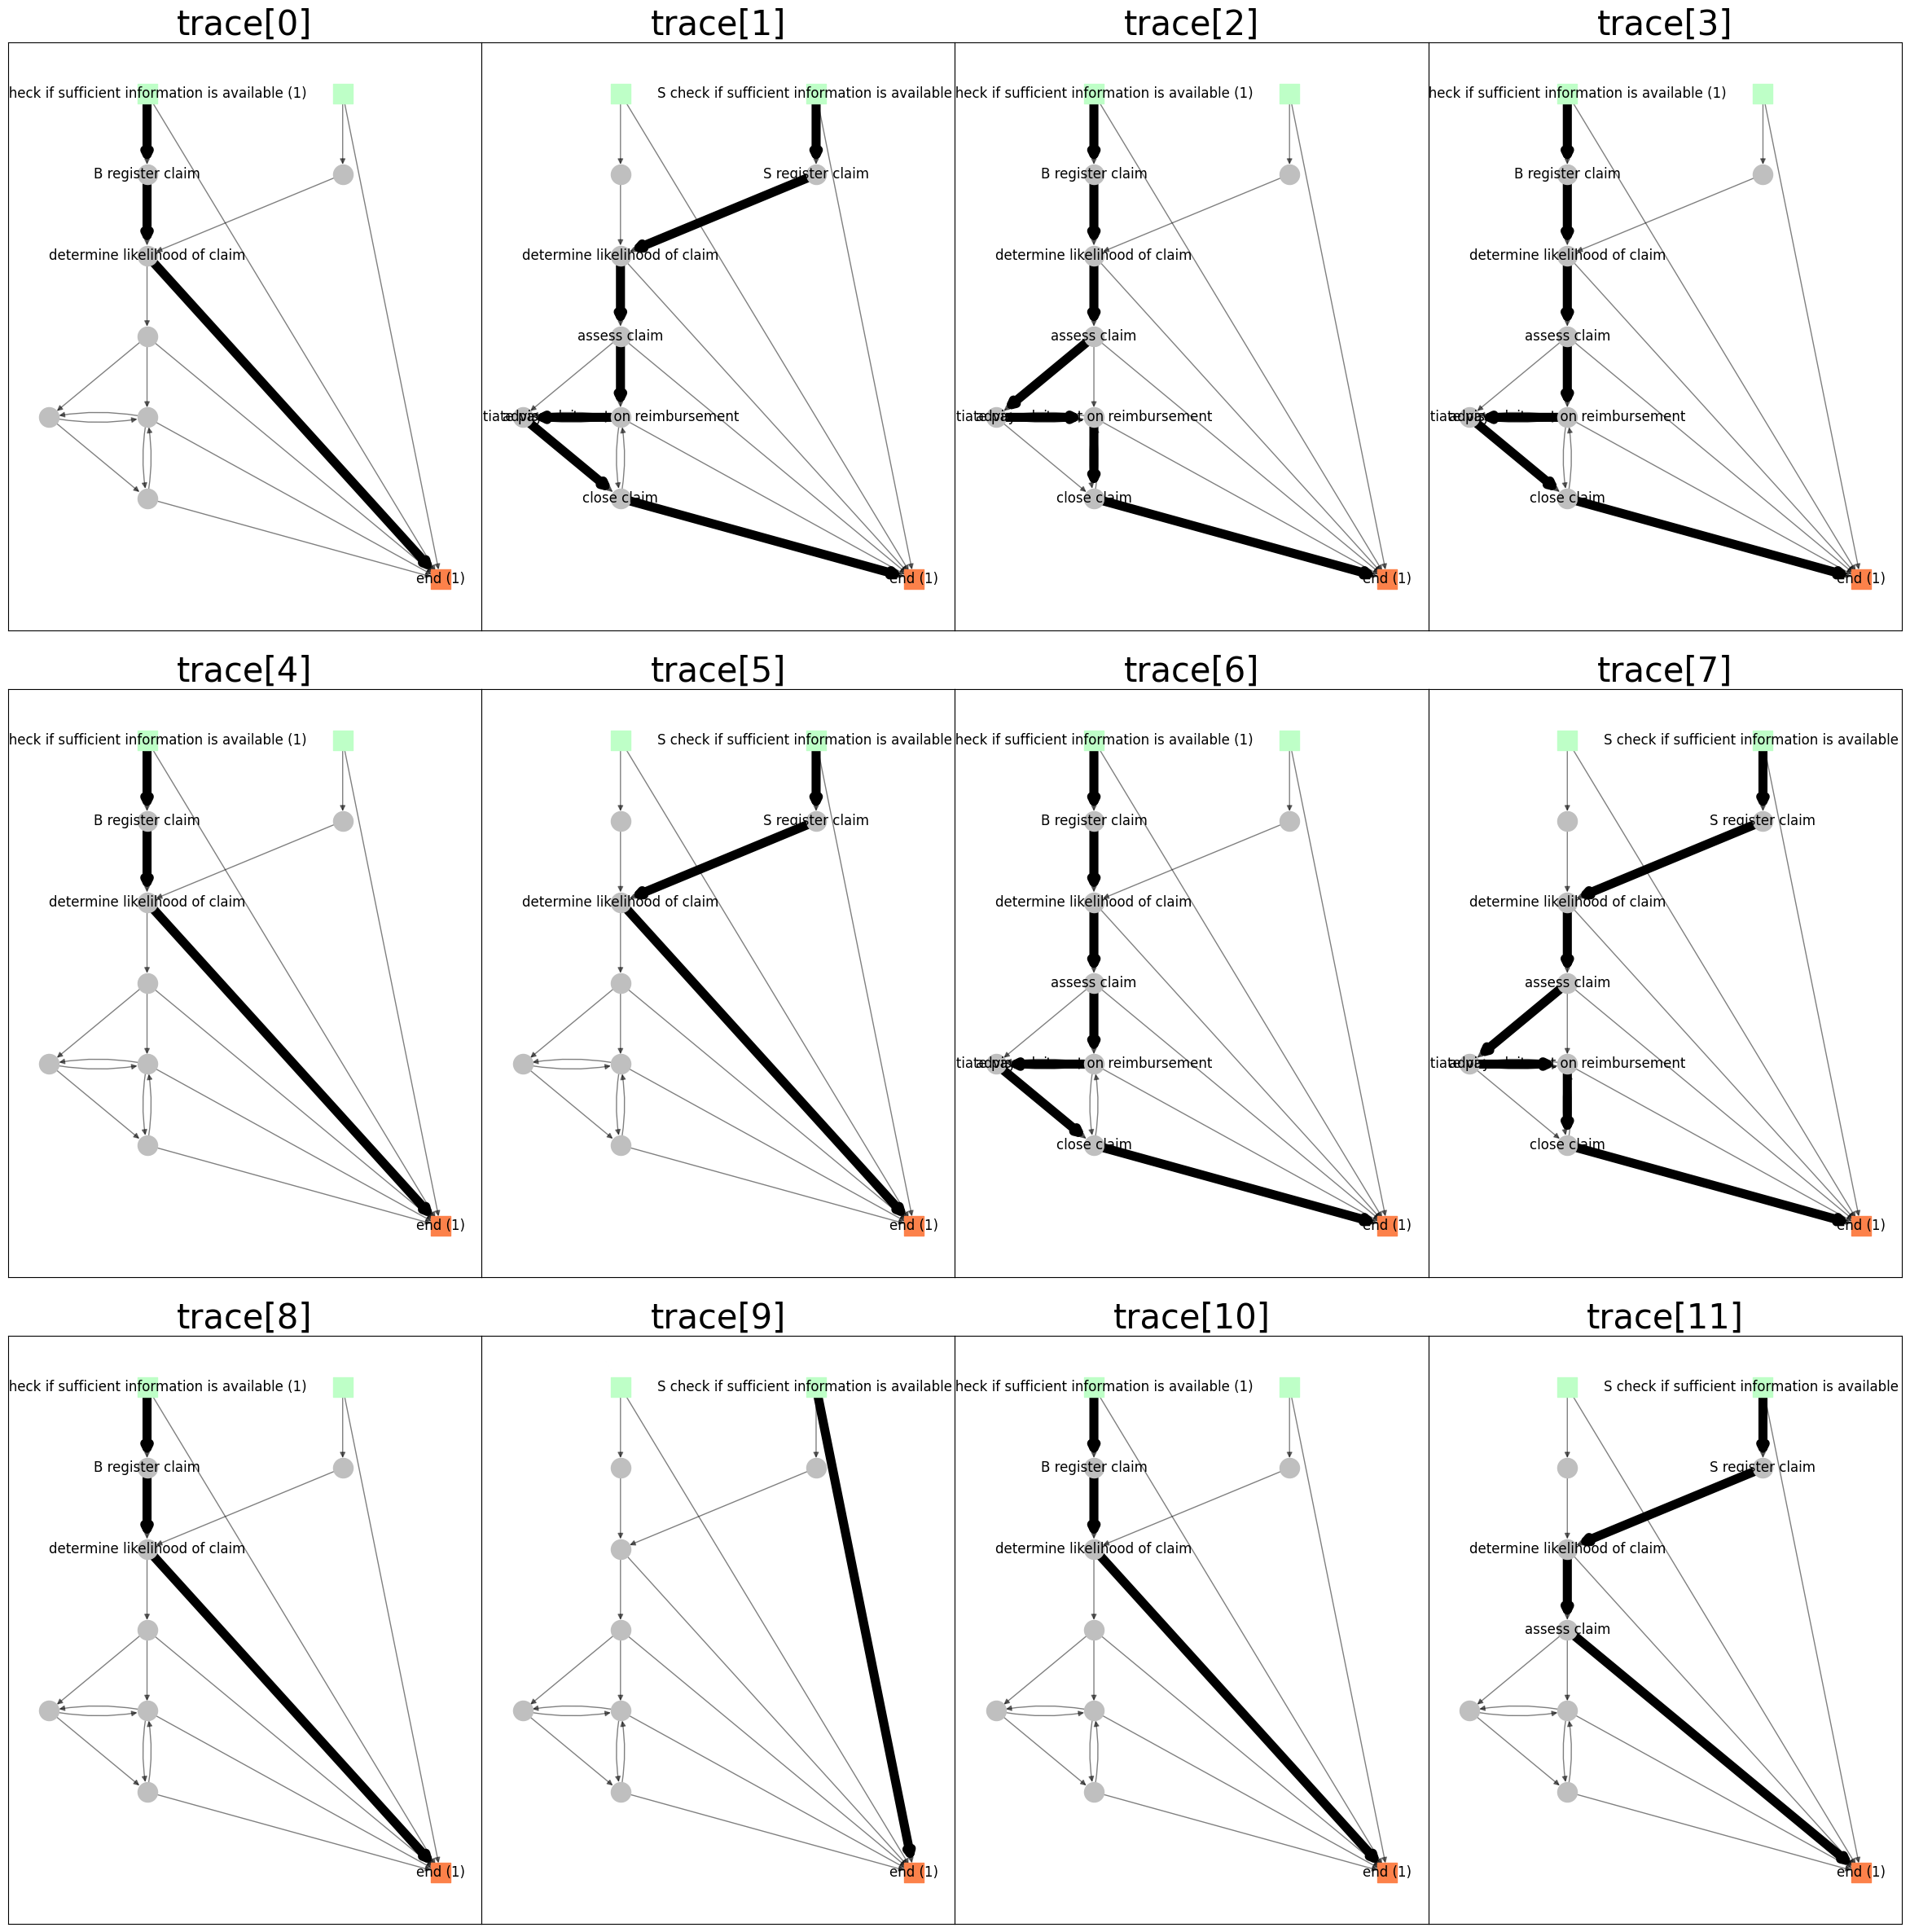

In [9]:
%autoreload
from maxes.analyze_sequence import draw_xes_log_graph__nodes, draw_xes_log_graph__edges, draw_xes_log_graph__node_labels

def draw_trace_graph_on_log_graph(log_graph: nx.DiGraph, trace_graph: nx.DiGraph, pos, ax):
    # Draw log graph components
    draw_xes_log_graph__nodes(log_graph, pos=pos, ax=ax)
    draw_xes_log_graph__edges(log_graph, pos=pos, ax=ax)

    # Draw trace graph components
    draw_xes_log_graph__node_labels(trace_graph, pos=pos, ax=ax)
    nx.draw_networkx_edges(trace_graph, ax=ax, pos=pos, width=8)

fig, axs = plt.subplots(3, 4)
fig.set_size_inches(30, 30)
fig.subplots_adjust(hspace=0.1, wspace=0)

for index, ax in enumerate(axs.reshape(-1)):
    trace_graph = traces_graphs[index]

    draw_trace_graph_on_log_graph(graph, trace_graph, pos=pos, ax=ax)

    ax.set_title(f"trace[{index}]", fontsize=30)

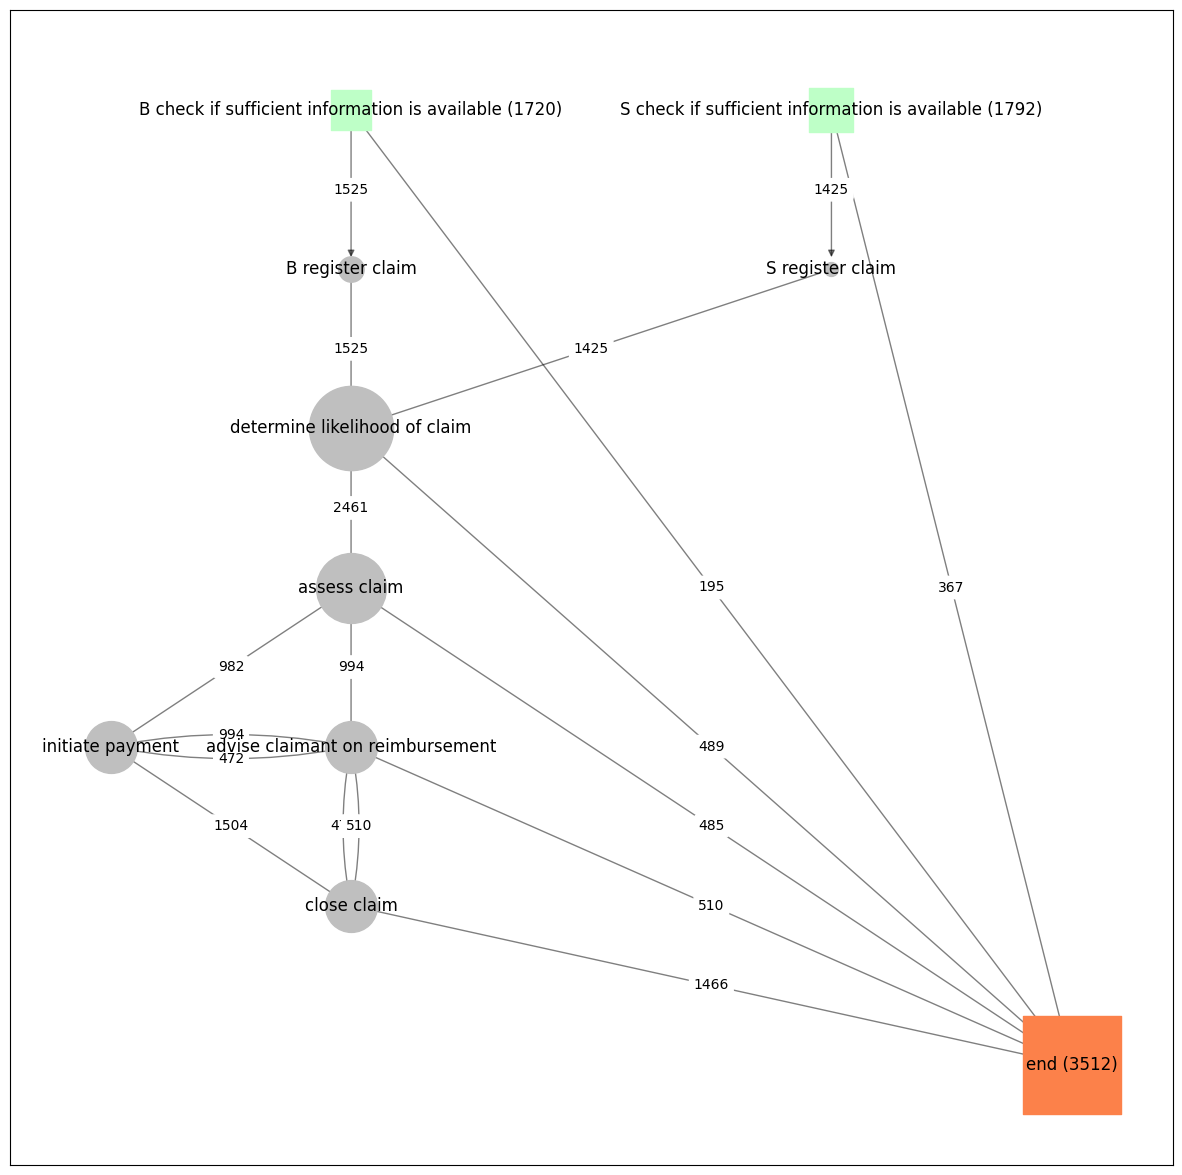

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 15)
maxes.analyze_sequence.draw_nx_graph(graph, edge_label="frequency", ax=ax, pos=pos)

In [11]:
list(graph.nodes)

['B check if sufficient information is available',
 'B register claim',
 'determine likelihood of claim',
 'end',
 'S check if sufficient information is available',
 'S register claim',
 'assess claim',
 'advise claimant on reimbursement',
 'initiate payment',
 'close claim']

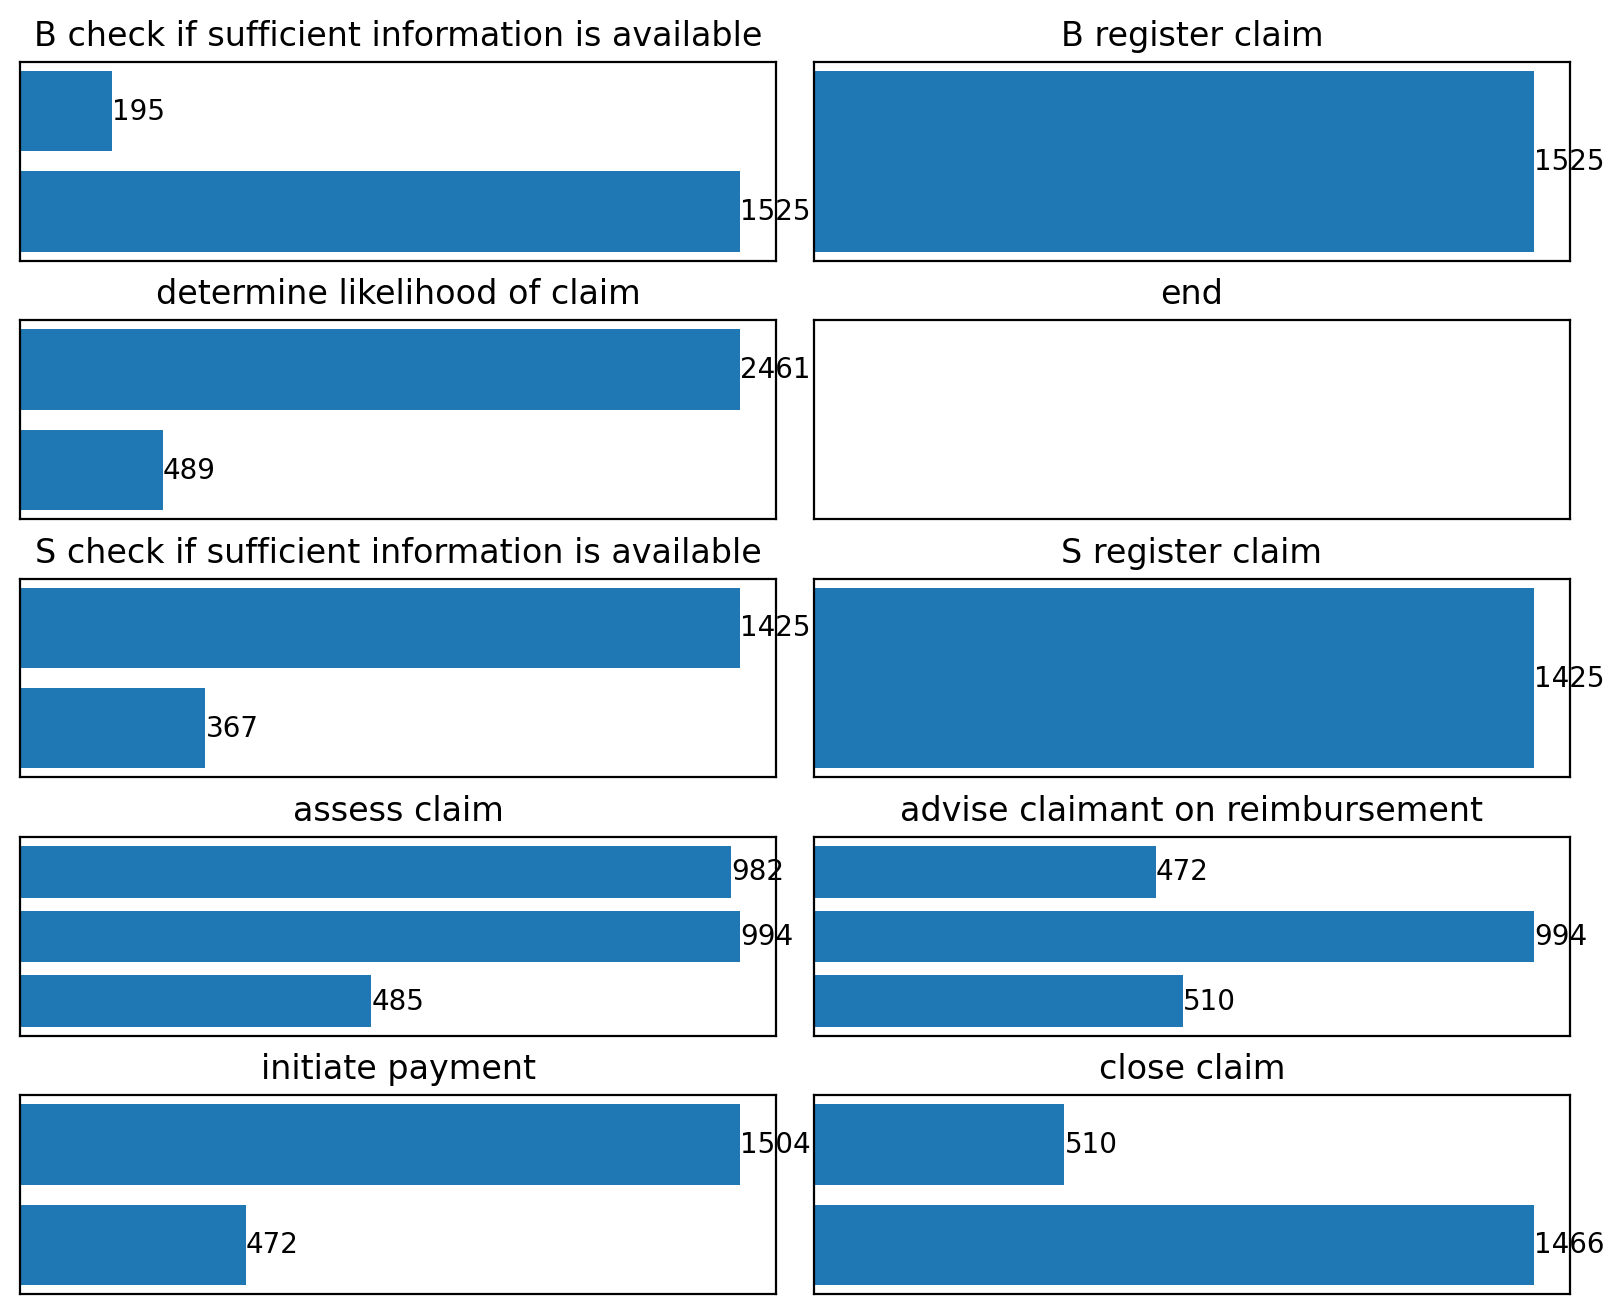

In [14]:
fig, axs = plt.subplots(5, 2)
fig.set_dpi(200)
fig.set_size_inches(10, 8)
fig.subplots_adjust(hspace=0.3, wspace=0.05)

nodes = list(graph.nodes)

for index, ax in enumerate(axs.reshape(-1)):
    node = nodes[index]
    data = [(node, data["frequency"]) for node, data in graph[node].items()]
    x = [i[0] for i in data]
    y = [i[1] for i in data]

    ax.barh(x, y, label=None)
    ax.set_xticks([])
    ax.set_yticks([])

    for bar in ax.containers:
        ax.bar_label(bar)

    ax.title.set_text(node)

In [20]:
from maxes.graphs import RandomWeightedTraverser

rng = np.random.default_rng(1)

original_traces_lengths = [len(trace.df) for trace in log_filtered.traces]

generator = RandomWeightedTraverser(
    rng,
    min_steps=min(original_traces_lengths),
    max_steps=max(original_traces_lengths),
    weight_feature_name="frequency"
)
generator.fit(graph)

traces = [
    pd.DataFrame({ "concept:name": generator.sample()[0] })
    for i in range(4)
]

for trace in traces:
    print(trace)

# print("\n".join(traces[0]))

                                     concept:name
0  S check if sufficient information is available
1                                S register claim
2                   determine likelihood of claim
3                                             end
                                     concept:name
0  S check if sufficient information is available
1                                S register claim
2                   determine likelihood of claim
3                                    assess claim
4                                initiate payment
5                                     close claim
6                                             end
                                     concept:name
0  B check if sufficient information is available
1                                B register claim
2                   determine likelihood of claim
3                                    assess claim
4                advise claimant on reimbursement
5                                     close claim


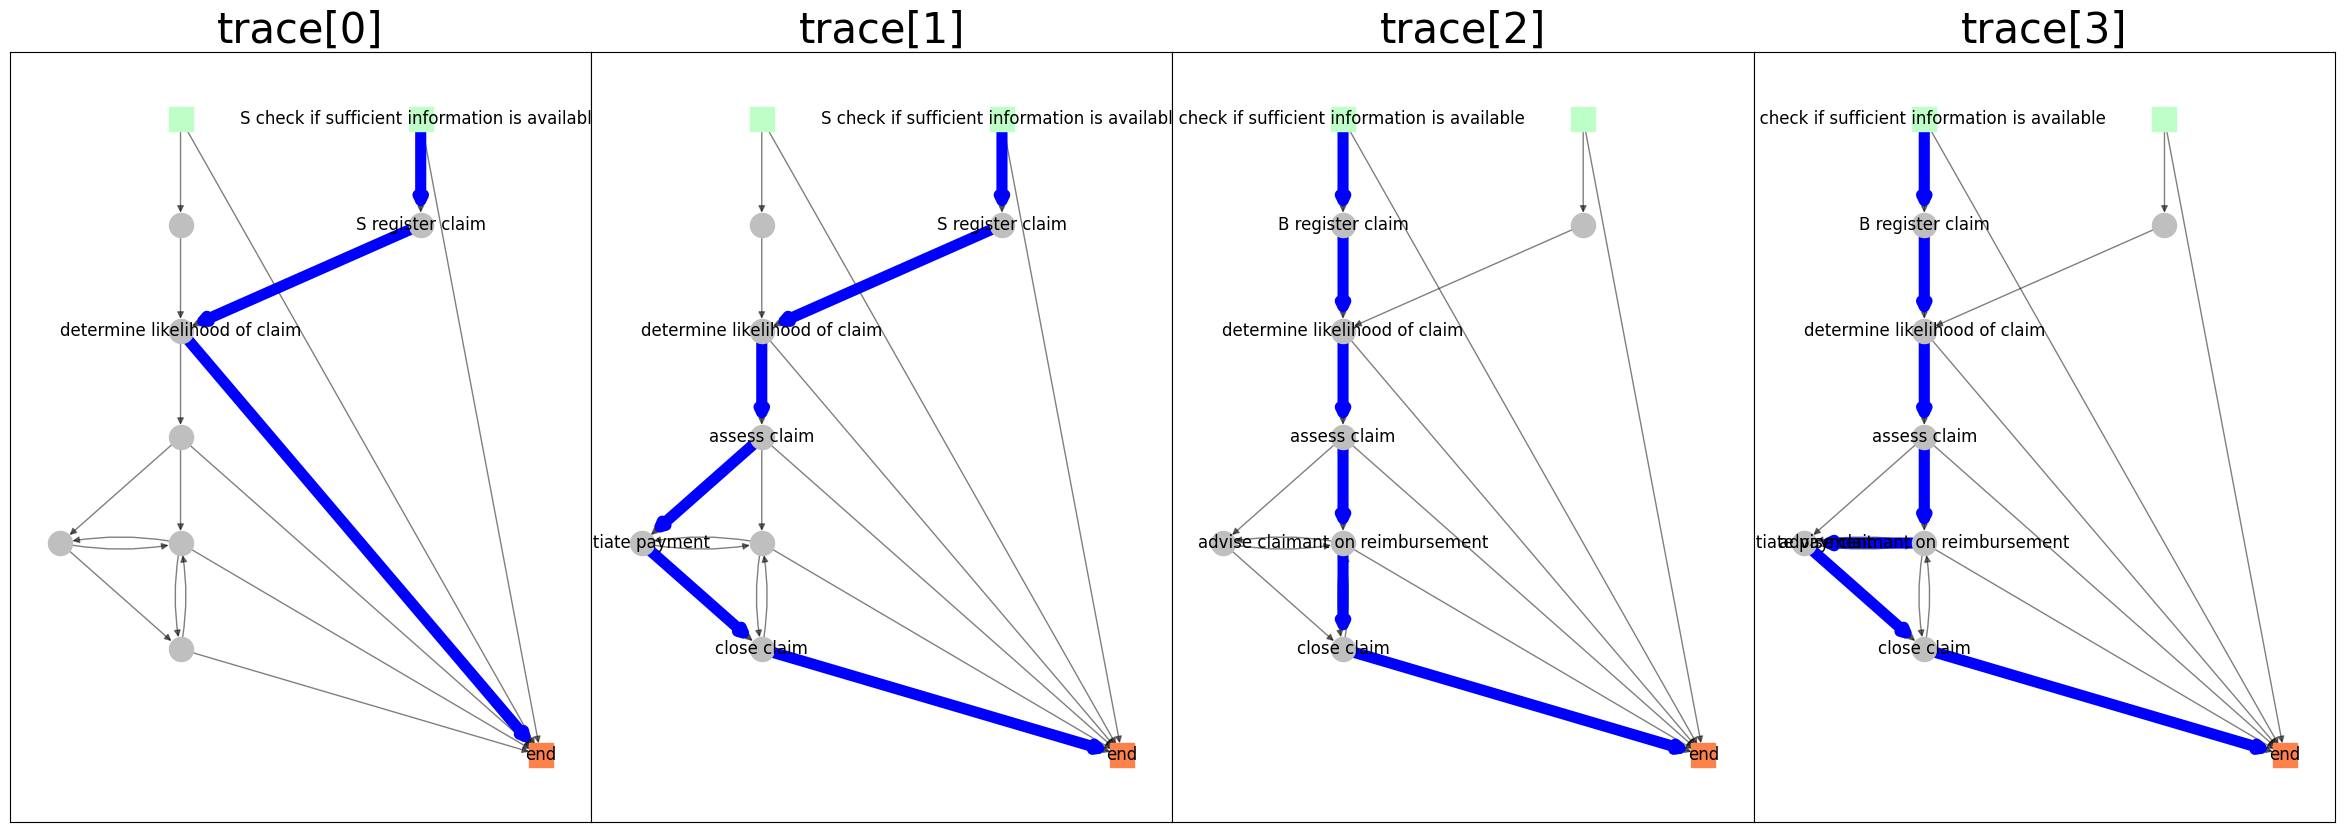

In [21]:
%autoreload
from maxes.analyze_sequence import draw_xes_log_graph__nodes, draw_xes_log_graph__edges, draw_xes_log_graph__node_labels

def create_graph_from_sequence(sequence):
    graph = nx.DiGraph()

    for previous_event, next_event in zip(sequence, sequence[1:]):
        graph.add_edge(previous_event, next_event)

    return graph

def draw_trace_graph_on_log_graph(log_graph: nx.DiGraph, trace_graph: nx.DiGraph, pos, ax):
    # Draw log graph components
    draw_xes_log_graph__nodes(log_graph, pos=pos, ax=ax)
    draw_xes_log_graph__edges(log_graph, pos=pos, ax=ax)

    # Draw trace graph components
    draw_xes_log_graph__node_labels(trace_graph, pos=pos, ax=ax)
    nx.draw_networkx_edges(trace_graph, ax=ax, pos=pos, width=8, edge_color="blue")

fig, axs = plt.subplots(1, 4)
fig.set_size_inches(30, 10)
fig.subplots_adjust(hspace=0.1, wspace=0)

for index, ax in enumerate(axs.reshape(-1)):
    trace_sequence = traces[index]['concept:name']
    trace_graph = create_graph_from_sequence(trace_sequence)

    draw_trace_graph_on_log_graph(graph, trace_graph, pos=pos, ax=ax)

    ax.set_title(f"trace[{index}]", fontsize=30)

We can expand algorithm to work on multiple keys as nodes

In [29]:
%autoreload
from maxes.generators.xes_generator.xes_generator3 import XesGenerator3 as XesGenerator

generator = XesGenerator()
generator.fit(log)

graph = generator.sequence_graph_;

In [30]:
pos = nx.kamada_kawai_layout(graph)

# Adjust auto-generated positions a bit
pos[('B check if sufficient information is available', 'start')] = [0.24949578, 0.82710757]
pos[('B check if sufficient information is available', 'complete')] = [0.07881691, 0.56040925]
pos[('B register claim', 'start')] = [-0.2159159 ,  0.75723339]
pos[('B register claim', 'complete')] = [-0.4492646 ,  0.58420182]

pos['S check if sufficient information is available', 'start'] = [0.44950886, 0.58711778]
pos['S check if sufficient information is available', 'complete'] = [0.27881373, 0.32042399]
pos['S register claim', 'start'] = [-0.01592852,  0.4572488]
pos['S register claim', 'complete'] = [-0.24927991,  0.34420121];

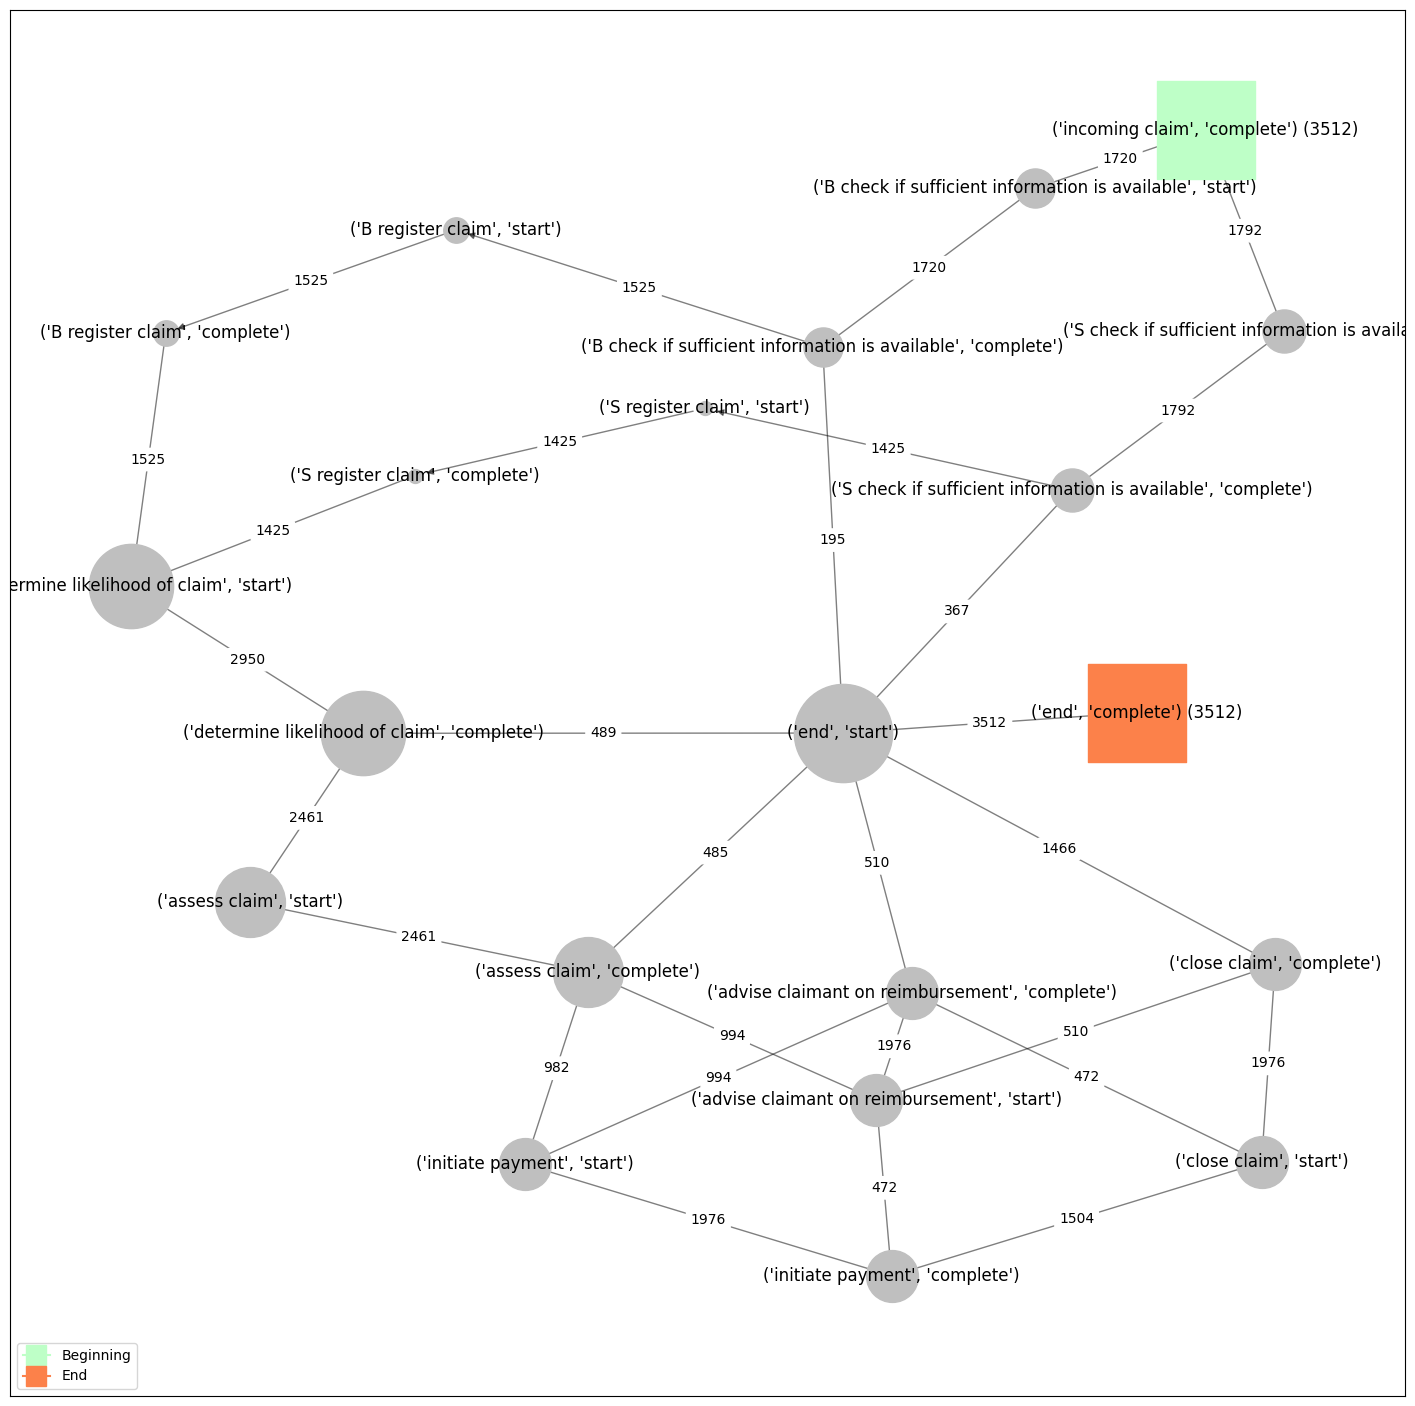

In [31]:
%autoreload
import matplotlib.lines
import maxes.analyze_sequence

graph = generator.sequence_graph_

plt.show()

fig, ax = plt.subplots()
fig.set_size_inches(18, 18)
maxes.analyze_sequence.draw_nx_graph(graph, edge_label="frequency", ax=ax, pos=pos)

node_line_first = matplotlib.lines.Line2D(
    [], [], color=maxes.analyze_sequence.NODE_COLOR_FIRST, marker='s', markersize=15, label='Beginning')

node_line_last = matplotlib.lines.Line2D(
    [], [], color=maxes.analyze_sequence.NODE_COLOR_LAST, marker='s', markersize=15, label='End')
ax.legend(handles=[node_line_first, node_line_last], loc='lower left');

In [106]:
from maxes.graphs import RandomWeightedTraverser

rng = np.random.default_rng(3)

original_traces_lengths = [len(trace.df) for trace in log.traces]

sequence_generator = RandomWeightedTraverser(
    rng,
    min_steps=min(original_traces_lengths),
    max_steps=max(original_traces_lengths),
    weight_feature_name="frequency"
)
sequence_generator.fit(graph)

generated_traces = [
    pd.DataFrame(sequence_generator.sample()[0], columns=["concept:name", "lifecycle:transition"])
    for i in range(4)
]

for trace in generated_traces:
    display(trace)

# print("\n".join(traces[0]))

,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,assess claim,start
8,assess claim,complete
9,advise claimant on reimbursement,start


,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,assess claim,start
8,assess claim,complete
9,initiate payment,start


,concept:name,lifecycle:transition
0,incoming claim,complete
1,S check if sufficient information is available,start
2,S check if sufficient information is available,complete
3,S register claim,start
4,S register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,end,start
8,end,complete


,concept:name,lifecycle:transition
0,incoming claim,complete
1,B check if sufficient information is available,start
2,B check if sufficient information is available,complete
3,B register claim,start
4,B register claim,complete
5,determine likelihood of claim,start
6,determine likelihood of claim,complete
7,assess claim,start
8,assess claim,complete
9,initiate payment,start


# 2. Generate "time:timestamp" attribute

Algorithm generates time attribute per 2 steps:
- Generate beginning time of a trace
- Generate time for each event transition

For both cases, we use KDE model.

In [93]:
%autoreload
from maxes.generators.xes_generator.xes_generator3 import XesGenerator3 as XesGenerator

transition_models_kwargs = {
    (('incoming claim', 'complete'), ('B check if sufficient information is available', 'start')): {
        "bandwidth": 20,
    },
    (('incoming claim', 'complete'), ('S check if sufficient information is available', 'start')): {
        "bandwidth": 10,
    },
    (('B register claim', 'start'), ('B register claim', 'complete')): {
        "bandwidth": 10,
    },
    (('B register claim', 'complete'), ('determine likelihood of claim', 'start')): {
        "bandwidth": 200,
    },
}
generator = XesGenerator(transition_models_kwargs=transition_models_kwargs)
generator.fit(log);

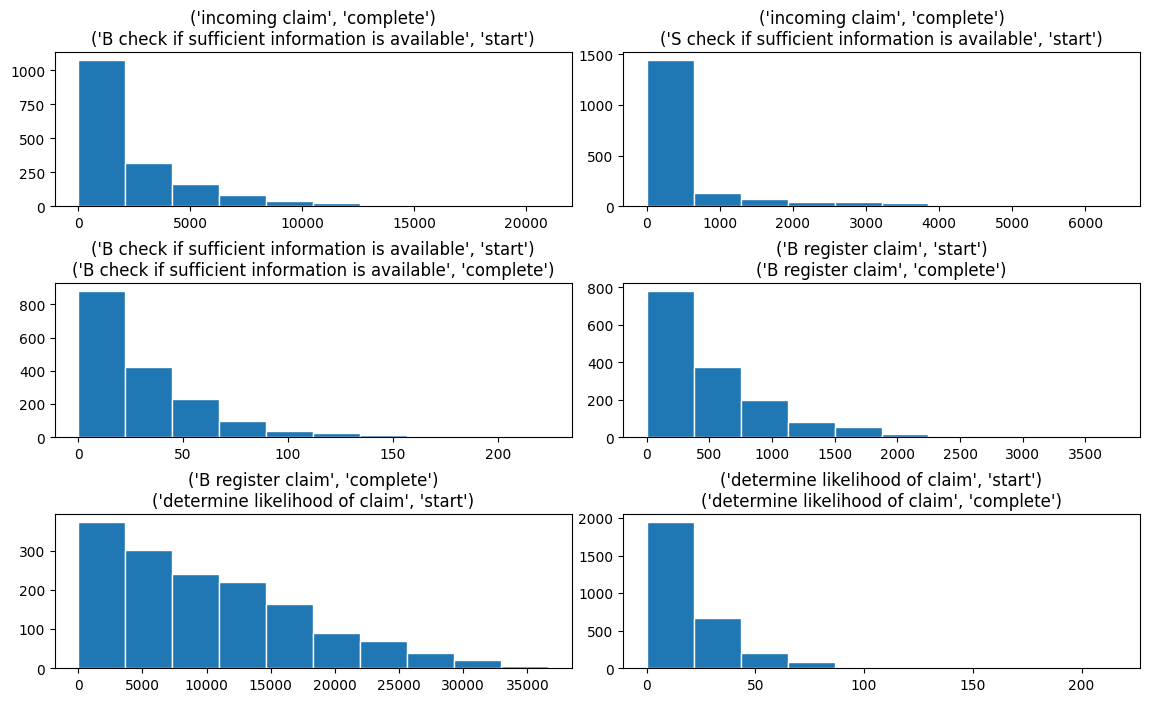

In [69]:
edges = list(generator.sequence_graph_.edges())

edges = [
    (('incoming claim', 'complete'), ('B check if sufficient information is available', 'start')),
    (('incoming claim', 'complete'), ('S check if sufficient information is available', 'start')),
    (('B check if sufficient information is available', 'start'), ('B check if sufficient information is available', 'complete')),
    (('B register claim', 'start'), ('B register claim', 'complete')),
    (('B register claim', 'complete'), ('determine likelihood of claim', 'start')),
    (('determine likelihood of claim', 'start'), ('determine likelihood of claim', 'complete')),
]

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5, wspace=0.1)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    transition_durations = generator.sequence_graph_.edges[edge]["transition_durations"]
    seconds = [duration.seconds for duration in transition_durations]

    # seconds_series = pd.Series(seconds)
    # seconds_series.describe()

    ax.hist(seconds, edgecolor='white')

    first, second = edge
    ax.set_title(f"{first}\n{second}")

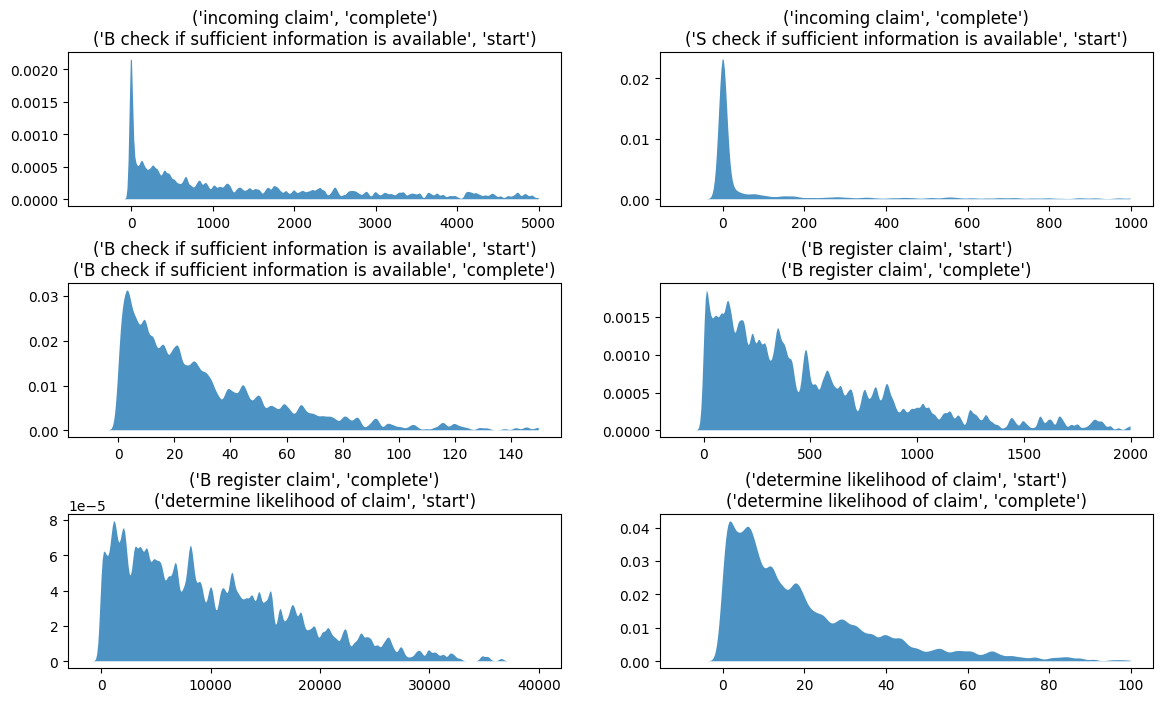

In [70]:
intervals = [
    [-500, 5000],
    [-100, 1000],
    [-10, 150],
    [-100, 2000],
    [-1000, 40000],
    [-10, 100]
]

def draw_kde_for_transition(transition_name: str, ax, interval, alpha=0.8):
    transition_data = generator.sequence_graph_.edges[transition_name]
    model = transition_data["duration_generator"]

    x = np.linspace(interval[0], interval[1], 400)

    y = np.exp(model.kde_.score_samples(x[:, None]))

    ax.fill_between(x, y, alpha=alpha);

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    interval = intervals[index]
    draw_kde_for_transition(edge, interval=interval, ax=ax, alpha=0.8)
    first, second = edge
    ax.set_title(f"{first}\n{second}")

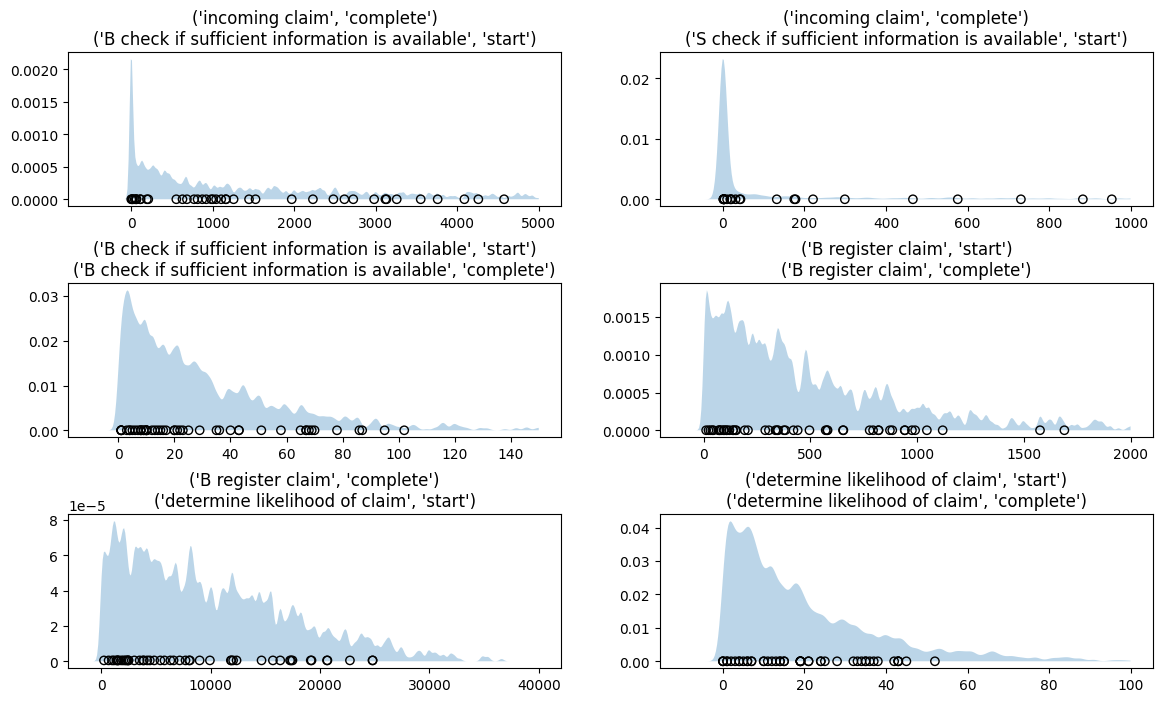

In [71]:
def draw_kde_transition_samples(transition_name: str, interval: tuple[float, float], ax):
    model = generator.sequence_graph_.edges[transition_name]["duration_generator"]

    samples_x = [
        sample.seconds
        for sample in model.sample(n_samples=50)
        if sample.seconds < interval[1]
    ]

    samples_y = [0.0000005 for sample in samples_x]

    ax.scatter(samples_x, samples_y, facecolors='none', edgecolors='black')

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(14, 8)
fig.subplots_adjust(hspace=0.5)

for index, ax in enumerate(axs.reshape(-1)):
    edge = edges[index]
    interval = intervals[index]
    draw_kde_for_transition(edge, interval=interval, ax=ax, alpha=0.3)
    draw_kde_transition_samples(edge, interval, ax=ax)
    first, second = edge
    ax.set_title(f"{first}\n{second}")

In [102]:
len(generated_trace)

17

In [96]:
list(itertools.pairwise(range(len(generated_trace))))

[(0, 1),
 (1, 2),
 (2, 3),
 (3, 4),
 (4, 5),
 (5, 6),
 (6, 7),
 (7, 8),
 (8, 9),
 (9, 10),
 (10, 11),
 (11, 12),
 (12, 13),
 (13, 14),
 (14, 15),
 (15, 16),
 (16, 17)]

In [ ]:
import itertools

generated_trace = generated_traces[0]
generated_trace.loc[0, "time:timestamp"] = generator.trace_beginning_timestamp_generator_.sample()[0]

for current_event_index, next_event_index in itertools.pairwise(range(len(generated_trace))):
    current_event = generated_trace.iloc[current_event_index]
    next_event = generated_trace.iloc[next_event_index]

    current_event_key = (current_event["concept:name"], current_event["lifecycle:transition"])
    next_event_key = (next_event["concept:name"], next_event["lifecycle:transition"])

    edge = (current_event_key, next_event_key)

    duration_generator = generator.sequence_graph_.edges[edge]["duration_generator"]
    sample_duration = duration_generator.sample()[0]
    next_event_timestamp = current_event["time:timestamp"] + sample_duration

    generated_trace.loc[next_event_index, "time:timestamp"] = next_event_timestamp

generated_trace

,concept:name,lifecycle:transition,time:timestamp
0,incoming claim,complete,1970-01-01 02:21:53.310006+00:00
1,B check if sufficient information is available,start,1970-01-01 02:46:43.332882+00:00
2,B check if sufficient information is available,complete,1970-01-01 02:46:54.472839+00:00
3,B register claim,start,1970-01-01 02:46:55.120207+00:00
4,B register claim,complete,1970-01-01 02:47:31.039719+00:00
5,determine likelihood of claim,start,1970-01-01 04:49:10.447382+00:00
6,determine likelihood of claim,complete,1970-01-01 04:50:12.954913+00:00
7,assess claim,start,1970-01-01 04:50:13.537935+00:00
8,assess claim,complete,1970-01-01 04:53:50.510995+00:00
9,advise claimant on reimbursement,start,1970-01-01 04:53:50.131152+00:00


# 3. Event attributes generation

When generating attributes data, we can associate each attribute with previously generated attributes, like `concept:name`.

In [113]:
from sklearn.preprocessing import OneHotEncoder

input_encoder = OneHotEncoder()
X_series = log.df["concept:name"]
X_np = np.array(X_series).reshape(-1, 1)
X = input_encoder.fit_transform(X_np)

X.toarray()[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [114]:
output_encoder = OneHotEncoder()
y_series = log.df["org:resource"]
y_np = np.array(y_series).reshape(-1, 1)
y = output_encoder.fit_transform(y_np)

y.toarray()[:5]

array([[0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.]])

In [115]:
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(X, y)

MLPClassifier()

In [116]:
generated_concept_name = np.array(generated_trace["concept:name"]).reshape(-1, 1)
X = input_encoder.transform(generated_concept_name)
y_pred = model.predict(X)
generated_org_resource = output_encoder.inverse_transform(y_pred).ravel()

generated_trace["org:resource"] = generated_org_resource

generated_trace

,concept:name,lifecycle:transition,time:timestamp,org:resource
0,incoming claim,complete,1970-01-01 02:21:53.310006+00:00,customer
1,B check if sufficient information is available,start,1970-01-01 02:46:43.332882+00:00,Call Centre Agent Brisbane
2,B check if sufficient information is available,complete,1970-01-01 02:46:54.472839+00:00,Call Centre Agent Brisbane
3,B register claim,start,1970-01-01 02:46:55.120207+00:00,Call Centre Agent Brisbane
4,B register claim,complete,1970-01-01 02:47:31.039719+00:00,Call Centre Agent Brisbane
5,determine likelihood of claim,start,1970-01-01 04:49:10.447382+00:00,Claims handler
6,determine likelihood of claim,complete,1970-01-01 04:50:12.954913+00:00,Claims handler
7,assess claim,start,1970-01-01 04:50:13.537935+00:00,Claims handler
8,assess claim,complete,1970-01-01 04:53:50.510995+00:00,Claims handler
9,advise claimant on reimbursement,start,1970-01-01 04:53:50.131152+00:00,Claims handler


In [ ]:
class AttributeGenerator:
    def __init__(self, input_columns, output_column):
        self.input_columns = input_columns
        self.output_column = output_column

    def fit(self, df):
        self.input_encoder = OneHotEncoder()
        X_series = df[self.input_columns]
        X_np = np.array(X_series).reshape(-1, 1)
        X = self.input_encoder.fit_transform(X_np)

        self.output_encoder = OneHotEncoder()
        y_series = df[self.output_column]
        y_np = np.array(y_series).reshape(-1, 1)
        y = self.output_encoder.fit_transform(y_np)

        self.model = MLPClassifier()
        self.model.fit(X, y)

        return self

    def generate(self, df: pd.DataFrame):
        generated_concept_name = np.array(df[self.input_columns]).reshape(-1, 1)
        X = self.input_encoder.transform(generated_concept_name)
        y_pred = self.model.predict(X)
        generated_org_resource = self.output_encoder.inverse_transform(y_pred).ravel()

        df = df.copy()

        df[self.output_column] = generated_org_resource

        return df

In [ ]:
class AttributeGenerator:
    def __init__(self, input_columns, output_column):
        self.input_columns = input_columns
        self.output_column = output_column

    def fit(self, df):
        X = df[self.input_columns]
        y = df[self.output_column]

        self.model = AttributePredictor()
        self.model.fit(X, y)

        return self

    def generate(self, df):
        X = df[self.input_columns]
        y_pred = self.model.predict(X)

        df = df.copy()
        df[self.output_column] = y_pred

        return df

class AttributePredictor:
    def fit(self, X, y):
        self.input_encoder = OneHotEncoder()
        X = self.input_encoder.fit_transform(X)

        self.output_encoder = OneHotEncoder()
        y_np = np.array(y).reshape(-1, 1)
        y = self.output_encoder.fit_transform(y_np)

        self.model = MLPClassifier()
        self.model.fit(X, y)

        return self

    def predict(self, X):
        X = self.input_encoder.transform(X)
        y_pred = self.model.predict(X)
        y_pred = self.output_encoder.inverse_transform(y_pred).ravel()

        return y_pred

In [182]:
generator_for_org_resource = AttributeGenerator(input_columns=["concept:name"], output_column="org:resource")
generator_for_org_resource.fit(log.df)

generator_for_location = AttributeGenerator(input_columns=["concept:name"], output_column="location")
generator_for_location.fit(log.df)

generator_for_call_centre = AttributeGenerator(input_columns=["concept:name"], output_column="call centre")
generator_for_call_centre.fit(log.df)

generator_for_outcome = AttributeGenerator(input_columns=["concept:name"], output_column="outcome")
generator_for_outcome.fit(log.df);

In [183]:
generated_trace = generator_for_org_resource.generate(generated_trace)
generated_trace = generator_for_location.generate(generated_trace)
generated_trace = generator_for_call_centre.generate(generated_trace)
generated_trace = generator_for_outcome.generate(generated_trace)

generated_trace

,concept:name,lifecycle:transition,time:timestamp,org:resource,location,call centre,outcome
0,incoming claim,complete,1970-01-01 02:21:53.310006+00:00,customer,NaN,Sydney,NaN
1,B check if sufficient information is available,start,1970-01-01 02:46:43.332882+00:00,Call Centre Agent Brisbane,Brisbane,NaN,NaN
2,B check if sufficient information is available,complete,1970-01-01 02:46:54.472839+00:00,Call Centre Agent Brisbane,Brisbane,NaN,NaN
3,B register claim,start,1970-01-01 02:46:55.120207+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN
4,B register claim,complete,1970-01-01 02:47:31.039719+00:00,Call Centre Agent Brisbane,NaN,NaN,NaN
5,determine likelihood of claim,start,1970-01-01 04:49:10.447382+00:00,Claims handler,NaN,NaN,NaN
6,determine likelihood of claim,complete,1970-01-01 04:50:12.954913+00:00,Claims handler,NaN,NaN,NaN
7,assess claim,start,1970-01-01 04:50:13.537935+00:00,Claims handler,NaN,NaN,NaN
8,assess claim,complete,1970-01-01 04:53:50.510995+00:00,Claims handler,NaN,NaN,NaN
9,advise claimant on reimbursement,start,1970-01-01 04:53:50.131152+00:00,Claims handler,NaN,NaN,NaN


# 4. Evaluation

For event sequence, we can use common process mining metrics to evaluate quality of generated data. We can use fitness, precision and generalization.

For attributes generation we can use model accuracy metrics.

# 4.1 PM metrics

In [185]:
generated_traces[0]

,concept:name,lifecycle:transition,time:timestamp,org:resource
0,incoming claim,complete,1970-01-01 02:21:53.310006+00:00,customer
1,B check if sufficient information is available,start,1970-01-01 02:46:43.332882+00:00,Call Centre Agent Brisbane
2,B check if sufficient information is available,complete,1970-01-01 02:46:54.472839+00:00,Call Centre Agent Brisbane
3,B register claim,start,1970-01-01 02:46:55.120207+00:00,Call Centre Agent Brisbane
4,B register claim,complete,1970-01-01 02:47:31.039719+00:00,Call Centre Agent Brisbane
5,determine likelihood of claim,start,1970-01-01 04:49:10.447382+00:00,Claims handler
6,determine likelihood of claim,complete,1970-01-01 04:50:12.954913+00:00,Claims handler
7,assess claim,start,1970-01-01 04:50:13.537935+00:00,Claims handler
8,assess claim,complete,1970-01-01 04:53:50.510995+00:00,Claims handler
9,advise claimant on reimbursement,start,1970-01-01 04:53:50.131152+00:00,Claims handler


In [188]:
generated_log = generated_trace
generated_log['case:concept:name'] = 0

In [189]:
import pm4py

from pm4py.algo.evaluation.replay_fitness.variants import token_replay as fitness_tbr
from pm4py.algo.evaluation.generalization.variants import token_based as generalization_tbr
from pm4py.algo.evaluation.precision.variants import etconformance_token as precision_tbr

log_pm4py = pm4py.read_xes(file_path)

net, im, fm = pm4py.discover_petri_net_inductive(log_pm4py)

fitness = fitness_tbr.apply(generated_log, net, im, fm, {'show_progress_bar': False})
print(fitness)
generalization = generalization_tbr.apply(generated_log, net, im, fm, {'show_progress_bar': False})
print(generalization)
precision = precision_tbr.apply(generated_log, net, im, fm, {'show_progress_bar': False})
print(precision)


parsing log, completed traces :: 100%|██████████| 3512/3512 [00:00<00:00, 8115.00it/s]


{'perc_fit_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 1.0, 'percentage_of_fitting_traces': 100.0}
0.054491761639712144
0.35416666666666663


## 4.2 Evaluating attribute generation accuracy

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

def evaluate_accuracy_score(input_columns, output_column):
    df = log.df
    X = df[input_columns]
    y = df[output_column].astype('str')

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

    model = AttributePredictor()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return accuracy_score(y_test, y_pred)

scores = pd.Series([
    evaluate_accuracy_score(["concept:name"], "org:resource"),
    evaluate_accuracy_score(["concept:name"], "location"),
    evaluate_accuracy_score(["concept:name"], "call centre"),
    evaluate_accuracy_score(["concept:name"], "outcome"),
])

print(scores)
print(f"mean: {scores.mean()}")

0    0.975899
1    1.000000
2    0.963242
3    0.931079
dtype: float64
mean: 0.967555266579974
